
### Import libraries and modules

In [1]:
import copy
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import create_inputsTable_UTOPIA
from functions.create_rateConstants_tabel import *
from functions.fillInteractions_df_fun import *
from functions.generate_modelObjects import *
from functions.generateRateConstants_particles import *
from functions.solver_SteadyState import *
from functions.extract_results import *
from functions.plot_results import *
from functions.massBalance import *
from functions.exposure_indicators_calculation import *
from functions.generate_MPinputs_table import *
from functions.save_results import *
from functions.loop_CTD_calculation import *
from functions.generate_compartmentFlows_tables import *
from functions.emission_fractions_calculation import *
from helpers.helpers import *

Set up path for inputs folder

In [2]:
##Set current working directory
cwd=os.getcwd()
inputs_path = cwd+"\inputs"

### Define run parameters

#### Define microplastics physical properties

In [3]:
MPdensity_kg_m3 = 900
MP_composition = "PE"
shape = "sphere"  # Fixed for now
N_sizeBins = 5  # Fixed, should not be changed. The 5 size bins are generated as being one order of magnitude appart and cover the range from mm to nm(i.e. 5000um, 500um, 50um, 5um, 0.5um)
big_bin_diameter_um = 5000  # This size can not be bigger than 10 mm (10000um) or smaller than 1 mm(1000um)
runName = MP_composition

MP_inputs={"MP_composition":MP_composition,"shape":shape,"N_sizeBins":N_sizeBins,"big_bin_diameter_um":big_bin_diameter_um,"runName":runName,"inputs_path":inputs_path}


In [4]:
Input_FI = 1
Input_t_half_deg_free = 66000 # in days (10 times slower than the rate of degradation (to form dissolved organics) shown in Pfohl et al. 2023 for TPU-arom)
Input_heter_deg_factor = 20
Input_biof_deg_factor = 1 / 2
Input_factor_deepWater_soilSurface = 10
Input_factor_sediment = 100

In [5]:
#t_frag_gen_FreeSurfaceWater = 248000  # in days derived from Pfohl et al. 2022 for TPU particles
Input_t_frag_gen_FreeSurfaceWater = 36  # in days
Input_biof_frag_factor = 2
Input_heter_frag_factor = 100

#In the surface beach compratment the fragmentation is enhanced or the same as in surface water layers (to be included in the assumptions)

In [6]:
# Size fraction:

Input_size_bin = "e"  # Chosse from size_dict
                      # Size fraction:
                      # a= 0.5 um = mp1, b= 5 um = mp2, c= 50 um = mp3, d= 500 um = mp4, e= 5000 um = mp5

Input_MP_form = "freeMP"  # Choose from MPforms_list above # Aggregation state (MP form):
                             # Free MP
                             # heterMP
                             # biofMP
                             # heterBiofMP

In [7]:
Input_emiss_comp = "Ocean_Surface_Water"
                                           #"Ocean_Surface_Water","Ocean_Mixed_Water","Ocean_Column_Water",
                                           #"Coast_Surface_Water","Coast_Column_Water","Surface_Freshwater",
                                           #"Bulk_Freshwater","Sediment_Freshwater",
                                           #"Beaches_Soil_Surface",Background_Soil_Surface"
                                           #"Impacted_Soil_Surface","Impacted_Soil","Air",

                                           
Input_input_flow_g_s = 250000 # Choose input flow (in g per second)

In [8]:
# write microplastics inputs file
mp_imputFile_name = write_MPinputs_table(
    MPdensity_kg_m3,
    MP_composition,
    shape,
    N_sizeBins,
    big_bin_diameter_um,
    runName,
    inputs_path,
)

#### Define Environmental Characteristics

##### Suspended particulates properties

In [9]:
# From Kooi et al. (2017)
v_a = 2.0e-16  # Volume of 1 algal cell [m-3]
r_a = ((3.0 / 4.0) * (v_a / math.pi)) ** (1.0 / 3.0)  # radius of algae [m]

spm_radius_um = r_a * 1e6
spm_density_kg_m3 = 1388  # REF: Kooi et al. (2017)

##### Compartment properties

In [10]:
comp_impFile_name = "\inputs_compartments.csv"  # Preloaded values, the user should be able to create its own inputs_compartments.csv file (via donwloading the file and typing news values without chaing the structure of the file) when a new file wants to be used the name should be changed here
comp_interactFile_name = (
    "\compartment_interactions.csv"  # Fixed, should not be modified
)

##### Generate model objects (via reading selected input files)

In [11]:
# Generate objects
boxName = "Utopia"  # fixed, do not modify

(
    system_particle_object_list,
    SpeciesList,
    spm,
    dict_comp,
    model_lists,
    particles_df,
) = generate_objects(
    inputs_path,
    boxName=boxName,
    MPforms_list=MPforms_list,
    comp_impFile_name=comp_impFile_name,
    comp_interactFile_name=comp_interactFile_name,
    mp_imputFile_name=mp_imputFile_name,
    spm_radius_um=spm_radius_um,
    spm_density_kg_m3=spm_density_kg_m3,
)


surfComp_list = [c for c in dict_comp if "Surface" in c]

#### Define Microplastics weathering properties


##### Select fragmentation style
In out approach each particle fractions into fragments of smaller sizes and the distribution is expresses via a fragment size distribution matrix (fsd), as descibed in https://microplastics-cluster.github.io/fragment-mnp/advanced-usage/fragment-size-distribution.html .  

In this matrix the smallest size fraction is in the first possition and we consider no fragmentation for this size class 

Below we define 4 different styles of fragmentation via defining the fsd for each of them. The user can choose form one of the proposed fragmentation styles or define its own fsd by including it in the frag_styles_dict following the structure below.

We provide a slider (to be done) where the user can select a fragmentation style by means of choosing a value of FI (fragmentation index) between 0 and 1 that describe two scenarios :

- Erosive fragmentation (FI=0): In this scenario the particles are being eroded on their surface and therefore most of their mass remain in their same size fraction and samall fraction in going to the samllest size bins. Its representative fsd is: 
  
    [[0, 0, 0, 0, 0],

    [1, 0, 0, 0, 0],

    [0.99, 0.01, 0, 0, 0],

    [0.999, 0, 0.001, 0, 0],
    
    [0.9999, 0, 0, 0.0001, 0],]

- Sequential fragmentation (FI=1): in this scenario each size fraction breacks down completely into the next smallest size bin.
Its representative fsd is: 

    [[0, 0, 0, 0, 0],

    [1, 0, 0, 0, 0],

    [0, 1, 0, 0, 0],

    [0, 0, 1, 0, 0],
    
    [0, 0, 0, 1, 0],]

By choosing a value between 0 and 1 the user can select a fragmentation style in between both extremes.

In [12]:
## Select a value for FI in the range 0-1 where:
frag_styles_dict = {0:"erosive_fragmentation",0.5:"mixed_fragmentation",1:"sequential_fragmentation"} ## Slider??
FI = Input_FI  # from slider or user imput

# Generate the fsd matrix
fsd = generate_fsd_matrix(FI)
# Create a dataframe from the fsd matrix
sizes = [list(model_lists["dict_size_coding"].keys())]
fsd_df = pd.DataFrame(fsd, index=sizes, columns=sizes)

# Save the fsd matrix (not sure if we need to save it-- to be revisited)
fsd_filename = os.path.join(inputs_path, "fsd.csv")
fsd_df.to_csv(fsd_filename)

# Verify the sum of each row
row_sums = fsd.sum(axis=1)
print("\nSum of each row:")
for idx, sum_value in enumerate(row_sums):
    print(f"Row {idx + 1}: {sum_value}")


Sum of each row:
Row 1: 0.0
Row 2: 1.0
Row 3: 1.0
Row 4: 1.0
Row 5: 1.0


In [13]:
frag_style = frag_styles_dict[FI]
frag_style ### We need this now for the save fiction but should be substituted for FI=x? so that we can choose any value in the range 0-1

'sequential_fragmentation'

##### Define Weathering processes input parameters

##### Degradation half time: thalf_deg_d

The model provides a default value for degradation time of Free MPs taken from Domercq et al. 2021 in the file (t_half_deg_free.csv):

The assumptions made for the definition of these degradation times: (NEW assumptions)

- Heteroaggregated particles degrade 10 times slower than the free MPs

- Biofouled particles degrade 2 times faster than the free MPs

- Both degradation and fragmentation rates are compartment dependent: we assume that in the 
  
  - surface water compartments both degradation and fragmentation are fastest
  - in soil surface and deeper water compartments both rates are 10 times slower (factor_deepWater_soilSurface)
  - in sediments and deeper soil compartments they both are 100 times slower (factor_sediment)

If the user want to provide its own values of thalf_deg_d the values can be modified in the following cells

In [14]:
t_half_deg_free = Input_t_half_deg_free # in days (10 times slower than the rate of degradation (to form dissolved organics) shown in Pfohl et al. 2023 for TPU-arom)
heter_deg_factor = Input_heter_deg_factor
biof_deg_factor = Input_biof_deg_factor

In [15]:
t_half_deg_heter = t_half_deg_free * heter_deg_factor
t_half_deg_biof = t_half_deg_free * biof_deg_factor
t_half_deg_biofHeter = t_half_deg_free * biof_deg_factor * heter_deg_factor

In [16]:
factor_deepWater_soilSurface = Input_factor_deepWater_soilSurface
factor_sediment = Input_factor_sediment

In [17]:
thalf_deg_d_dict = {
    "freeMP": t_half_deg_free,
    "heterMP": t_half_deg_heter,
    "biofMP": t_half_deg_biof,
    "heterBiofMP": t_half_deg_biofHeter,
} 

print(thalf_deg_d_dict)


{'freeMP': 66000, 'heterMP': 1320000, 'biofMP': 33000.0, 'heterBiofMP': 660000.0}


#### Heteroaggregation attachment efficiency: alpha_heter.

In [18]:
alpha_heter_filename = os.path.join(inputs_path, "alpha_heter.csv")
alpha_heter_df = pd.read_csv(alpha_heter_filename)
alpha_hetr_dict = alpha_heter_df.set_index("MP_form")["alpha_heter"].to_dict()

In [19]:
alpha_hetr_dict

{'freeMP': '0.01', 'heterMP': 'NAN', 'biofMP': '0.02', 'heterBiofMP': 'NAN'}

#### Timescales of fragmentation

The fragmentation timescales are deteremined from the stablished fragmentation half time of 36.5 days for the biggest size fraction in free form in the surface water compartments following the parameters chosen in Domercq et al. 2021.

In UTOPIA we include the following assumptions for fragmentation:

-heteroaggregated MPs fragmnet 100 slower than fragmentation of the Free MPs 
-biofouled and heteroaggregated will be two times slowed of those only heteroaggregated, following the same assumption as for free and biofouled. 

These values are used in the Domercq et al. 2021 paper and they are asumptions made from lack of current knowlegde

In [20]:
#t_frag_gen_FreeSurfaceWater = 248000  # in days derived from Pfohl et al. 2022 for TPU particles
t_frag_gen_FreeSurfaceWater = Input_t_frag_gen_FreeSurfaceWater  # in days
biof_frag_factor = Input_biof_frag_factor
heter_frag_factor = Input_heter_frag_factor

#In the surface beach compratment the fragmentation is enhanced or the same as in surface water layers (to be included in the assumptions)

In [21]:
process_inputs_df = create_inputsTable_UTOPIA(
    inputs_path,
    model_lists,
    thalf_deg_d_dict,
    alpha_hetr_dict,
    t_frag_gen_FreeSurfaceWater,
    biof_frag_factor,
    heter_frag_factor,
    factor_deepWater_soilSurface,
    factor_sediment,
    save_op="save",
)

#### Define emission scenario

Choose input flow (in g per second) and define in wich form and size the particles are released into the environment and specify the input flow for each compartment

In [22]:
# Size fraction:
# for the preloaded scenario:
# a= 0.5 um = mp1
# b= 5 um = mp2
# c= 50 um = mp3
# d= 500 um = mp4
# e= 5000 um = mp5
import string

size_codes = [letter for letter in string.ascii_lowercase[0:N_sizeBins]]
size_dict = dict(zip(size_codes, model_lists["dict_size_coding"].values()))

# Aggregation state (MP form):
# A= Free MP
# B= heteroaggregatedMP
# C= biofouled MP
# D= biofouled and heteroaggregated MP
MPforms_list = ["freeMP", "heterMP", "biofMP", "heterBiofMP"]
particle_forms_coding = dict(zip(MPforms_list, ["A", "B", "C", "D"]))
MP_form_dict_reverse = {v: k for k, v in particle_forms_coding.items()}

##### Select size bin and form

In [23]:
size_bin = Input_size_bin  # Chosse from size_dict
MP_form = Input_MP_form  # Choose from MPforms_list above

##### Type input flow in g/s

If inputs are only made to one compartment:

In [24]:
emiss_comp = Input_emiss_comp  # Select compartment from the compartment list
input_flow_g_s = Input_input_flow_g_s # Choose input flow (in g per second)


In [25]:
#Global emission estimate of plastics (Macro) to the ocean is 8Mt per year
8e12/365/24/60/60

253678.33587011666

Based on estimates by the Global plastics budget and cycle for the year 2015 based on best-available observations and model estimates. (REF: Sonke et al. Microplastics and Nanoplastics (2022) 2:28 https://doi.org/10.1186/s43591-022-00048-w)
Emissions from rivers into the oceans: 3.3 Tg (10^12g) per year: 104642g/sec


In [26]:


q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Beaches_Soil_Surface": 0,
    "Beaches_Deep_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Impacted_Soil_Surface": 0,
    "Impacted_Soil": 0,
    "Air": 0,
}

q_mass_g_s_dict[emiss_comp] = input_flow_g_s

If emissions are made to several compartments type the input flows corresponding to the specific compartments in the following dictionary:

q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Urban_Soil_Surface": 0,
    "Urban_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Agricultural_Soil_Surface": 0,
    "Agricultural_Soil": 0,
    "Air": 0,
}

If inputs are made to different size classess and MP forms the following dictionary has to be used:


In [27]:
input_flow_filename = os.path.join(inputs_path, "inputFlows.csv")
input_flows_df = pd.DataFrame(
    list(q_mass_g_s_dict.items()), columns=["compartment", "q_mass_g_s"]
)
input_flows_df.to_csv(input_flow_filename, index=False)

In [28]:
# Generate dict of emission flows
particle_compartmentCoding = dict(
    zip(
        model_lists["compartmentNames_list"],
        list(range(len(model_lists["compartmentNames_list"]))),
    )
)
comp_dict_inverse = {v: k for k, v in particle_compartmentCoding.items()}

sp_imputs = []
q_mass_g_s = []
for compartment in q_mass_g_s_dict.keys():

    sp_imputs.append(
        size_bin
        + particle_forms_coding[MP_form]
        + str(particle_compartmentCoding[compartment])
        + "_"
        + boxName
    )
    q_mass_g_s.append(q_mass_g_s_dict[compartment])

imput_flows_g_s = dict(zip(sp_imputs, q_mass_g_s))

q_num_s = [
    mass_to_num(v, p.Pvolume_m3, p.Pdensity_kg_m3) if v != 0 else 0
    for k, v in zip(imput_flows_g_s.keys(), imput_flows_g_s.values())
    for p in system_particle_object_list
    if k == p.Pcode
]

# imput_flows_num_s = dict(zip(sp_imputs, q_num_s))

In [29]:
emission_inputs={"size_bin":size_bin, "MP_form":MP_form, "emiss_comp":emiss_comp, "imput_flows_g_s":imput_flows_g_s}

## Model Run Summary

In [30]:
saveName = (
    MP_composition
    + "_MP_Emissions_"
    + MP_form
    + "_"
    + str(size_dict[size_bin])
    + "_nm_"
    + "_FI:"
    + str(FI)
)

# Print model run summary

print("Model run: ")
print("Emissions flow (g/s): ", input_flow_g_s)
desired_key = next(key for key, value in q_mass_g_s_dict.items() if value > 0)
print("Receiving compartment/s: ", desired_key)
print("Emitted MP density (kg/m3): ", MPdensity_kg_m3)
print("Emitted MP shape: ", shape)
print("Emitted MP form: ", MP_form)
print("Emitted MP size (um): ", size_dict[size_bin])
print(saveName)

Model run: 
Emissions flow (g/s):  250000
Receiving compartment/s:  Ocean_Surface_Water
Emitted MP density (kg/m3):  900
Emitted MP shape:  sphere
Emitted MP form:  freeMP
Emitted MP size (um):  5000.0
PE_MP_Emissions_freeMP_5000.0_nm__FI:1


### Run Model

In [31]:

"""Estimate rate constants per particle"""

for particle in system_particle_object_list:
    generate_rateConstants(particle, spm, dict_comp, fsd, process_inputs_df)


## create rate constants table:
RC_df = create_rateConstants_table(system_particle_object_list)
df4 = RC_df.fillna(0)

# Plot rate constants (not implemented anymore)

"""(FIX RC for wet deposition, now its given as a list of rate constants per surface compartment only for dry deposition and wet depossition is turned off)This needs to be fixed also for the matrix of interactions and estimation of flows"""
rateConstants_df=df4
selected_columns = rateConstants_df.columns[3:]
data_raw=df4[selected_columns]
selected_data=data_raw.applymap(sum_if_list)
log_data = selected_data.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


# Violin Plot
#plt.figure(figsize=(10, 6))
#sns.violinplot(data=log_data)
#plt.yscale('log')
#plt.xticks(rotation=90)
#plt.title("Distribution of rate constants as log(k_s-1)")
#plt.show()


c:\Users\rakes\Pictures\Model\UTOPIA_model-main\functions\RC_generator.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  t_half_d = float(process_inputs_df.loc[cond, "thalf_deg_d"])
C:\Users\rakes\AppData\Local\Temp\ipykernel_7116\3235857518.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  selected_data=data_raw.applymap(sum_if_list)
C:\Users\rakes\AppData\Local\Temp\ipykernel_7116\3235857518.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_data = selected_data.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


In [32]:

"""Build Matrix of interactions"""

interactions_df = fillInteractions_fun_OOP(
    system_particle_object_list, SpeciesList, surfComp_list
)


"""SOLVE SYSTEM OF ODES"""


R, PartMass_t0 = solve_ODES_SS(
    system_particle_object_list=system_particle_object_list,
    q_num_s=0,
    imput_flows_g_s=imput_flows_g_s,
    interactions_df=interactions_df,
)

# Reformat results (R) dataframe
R["Size_Fraction_um"] = [size_dict[x[0]] for x in R.index]
R["MP_Form"] = [MP_form_dict_reverse[x[1]] for x in R.index]
R["Compartment"] = [comp_dict_inverse[float(x[2:-7])] for x in R.index]

Results = R[
    [
        "Compartment",
        "MP_Form",
        "Size_Fraction_um",
        "mass_g",
        "number_of_particles",
        "concentration_g_m3",
        "concentration_num_m3",
    ]
]

# Solve mass balance and print result
massBalance(R, system_particle_object_list, q_mass_g_s)


# Test that there are no negative results
for i, idx in zip(R["mass_g"], R.index):
    if i < 0:
        print("negative values in the solution for " + idx)
    else:
        pass

# Estimate mass and number fractions and extract ranking tables of the species with higest fractions to understand the distribution of the particles in the system by mass and number of particles

Results_extended, mf_shorted, nf_shorted = estimate_fractions(Results)

# Organise results in dictionary for plotting

Results_comp_dict = extract_by_comp(
    Results_extended.reset_index(), particle_compartmentCoding
)
Results_comp_organiced = extract_by_aggSt(Results_comp_dict, particle_forms_coding)

# Mass distribution by compartment

results_by_comp = extract_results_by_compartment(Results_extended, dict_comp)


### MASS BALANCE PER COMPARTMENT###

# Estimate mass flows due to the different particle fate process (transfer between compartments, elimination and transformation processes)


# Estimate outflows in mass (g/s) amd number/second
(tables_outputFlows, tables_outputFlows_number) = estimate_outFlows(
    system_particle_object_list, dict_comp
)

# Estimate imput flows from transport from other compartments
(tables_inputFlows, tables_inputFlows_num) = estimate_inFlows(
    tables_outputFlows, tables_outputFlows_number, dict_comp, surfComp_list
)

# Create flow dictionaries

# Decode index in input and output flow tables
flows_dict_mass = generate_flows_dict(
    tables_outputFlows, tables_inputFlows, size_dict, MP_form_dict_reverse
)

flows_dict_num = generate_flows_dict(
    tables_outputFlows_number, tables_inputFlows_num, size_dict, MP_form_dict_reverse
)

## Compartment mass balance

comp_mass_balance = {}
for comp in list(dict_comp.keys()):
    comp_mass_balance[comp] = compartment_massBalance(
        comp=comp,
        tables_outputFlows=tables_outputFlows,
        PartMass_t0=PartMass_t0,
        comp_dict_inverse=comp_dict_inverse,
        dict_comp=dict_comp,
        tables_inputFlows=tables_inputFlows,
    )

# Print compartment mass balance table
comp_mass_balance_df = pd.DataFrame.from_dict(comp_mass_balance, orient="index")


comp_mass_balance_df["Mass balance"] = [
    comp_mass_balance_df["Inflow"][c] - comp_mass_balance_df["Outflow"][c]
    for c in comp_mass_balance_df.index
]


# Add total steady state mass and number of particles concentrations to dataframe


comp_mass_balance_df["Concentration (g/m3)"] = [
    sum(Results_comp_dict[c].concentration_g_m3) for c in comp_mass_balance_df.index
]
comp_mass_balance_df["Concentration (N/m3)"] = [
    sum(Results_comp_dict[c].concentration_num_m3) for c in comp_mass_balance_df.index
]

print(comp_mass_balance_df["Mass balance"])

Difference inflow-outflow = -2.0556326489895582e-06
Ocean_Surface_Water        0.000000e+00
Ocean_Mixed_Water         -7.629395e-06
Ocean_Column_Water         3.637979e-12
Coast_Surface_Water       -3.576279e-07
Coast_Column_Water         0.000000e+00
Surface_Freshwater         0.000000e+00
Bulk_Freshwater            2.980232e-08
Sediment_Freshwater        0.000000e+00
Sediment_Ocean            -9.094947e-13
Sediment_Coast             1.136868e-13
Beaches_Soil_Surface       0.000000e+00
Beaches_Deep_Soil          0.000000e+00
Background_Soil_Surface    3.637979e-12
Background_Soil           -7.275958e-12
Impacted_Soil_Surface     -3.637979e-12
Impacted_Soil              0.000000e+00
Air                       -7.275958e-12
Name: Mass balance, dtype: float64


c:\Users\rakes\Pictures\Model\UTOPIA_model-main\functions\generate_compartmentFlows_tables.py:150: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tables_inputFlows[comp] = pd.concat(comp_input_flows).fillna(0)
c:\Users\rakes\Pictures\Model\UTOPIA_model-main\functions\generate_compartmentFlows_tables.py:151: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tables_inputFlows_num[comp] = pd.concat(comp_input_flows_num).fillna(0)
c:\Users\rakes\Pictures\Model\UTOPIA_model-main\functions\generate_compartmentFlows_tables.py:150: FutureWarning: Downcasting object d

In [33]:
for c,b in zip(comp_mass_balance_df.index,comp_mass_balance_df["Mass balance"]):
    if b > 1E-3:
        print ("The mass balance of {} is not withing the tolerance limints: mass balance = {}".format(c,round(b,2)))

In [34]:
""" Add iput and output flows dict to results extended dataframe"""

Results_extended = addFlows_to_results_df(
    Results_extended, flows_dict_mass, flows_dict_num
)

#Correct input flows to include also the transformation processess (e.g.heteroaggregation)
# Only working for mass at the moment, need to estimate steady state particle numbers 

from functions.fillInteractions_dictionaries import*
#This is all in mass units
interactions_pp_df=fillInteractions_fun_OOP_dict(
    system_particle_object_list, SpeciesList, surfComp_list)

# Create a dictionary of recieving inflows per particle taking the values from the interactions matrix
particle_inflows_dict_mass={}
particle_inflows_dict_number={}
for p in system_particle_object_list:
    inflows_p_mass=[]
    #inflows_p_num=[]
    for p2 in system_particle_object_list:
        interaction_rate=interactions_pp_df[p2.Pcode][p.Pcode]
        if type(interaction_rate) == dict:
            inflow={k: v * p2.Pmass_g_SS for k, v in interaction_rate.items()}
            inflows_p_mass.append(inflow)
            #inflows_p_num.append({k: v * p2.Pnum_g_SS for k, v in interaction_rate.items()})
        else:
            inflows_p_mass.append(interaction_rate)
            #inflows_p_num.append(interaction_rate)
    dict_list=[item for item in inflows_p_mass if isinstance(item, dict)]
    #dict_list_num=[item for item in inflows_p_num if isinstance(item, dict)]
    merged_dict={}
    #merged_dict_num={}
    for d in dict_list:
        for k, v in d.items():
            if k in merged_dict:
                merged_dict[k] += v
                #merged_dict_num[k] += v
            else:
                merged_dict[k] = v
                #merged_dict_num[k] = v
    
    particle_inflows_dict_mass[p.Pcode]=merged_dict
    #particle_inflows_dict_number[p.Pcode]=merged_dict_num
    
#Substitute the inputflow values in the results_extended dataframe:

for ele in particle_inflows_dict_mass:
    Results_extended.at[ele, "inflows_g_s"] = particle_inflows_dict_mass[ele]
    #Results_extended.at[ele, "inflows_num_s"] = particle_inflows_dict_number[ele]

Results_extended["Total_inflows_g_s"] = [
    sum(Results_extended.iloc[i].inflows_g_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_outflows_g_s"] = [
    sum(Results_extended.iloc[i].outflows_g_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_inflows_num_s"] = [
    sum(Results_extended.iloc[i].inflows_num_s.values())
    for i in range(len(Results_extended))
]

Results_extended["Total_outflows_num_s"] = [
    sum(Results_extended.iloc[i].outflows_num_s.values())
    for i in range(len(Results_extended))
]

""" Add iput and output flows dict to compartment results dataframe (results_by_comp)"""
results_by_comp = addFlows_to_results_df_comp(results_by_comp, flows_dict_mass, flows_dict_num)



In [35]:
from functions.fillInteractions_dictionaries import*
#This is all in mass units
interactions_pp_df=fillInteractions_fun_OOP_dict(
    system_particle_object_list, SpeciesList, surfComp_list
)
# Create a dictionary of recieving inflows per particle taking the values from the interactions matrix
particle_inflows_dict={}
for p in system_particle_object_list:
    inflows_p=[]
    for p2 in system_particle_object_list:
        interaction_rate=interactions_pp_df[p2.Pcode][p.Pcode]
        if type(interaction_rate) == dict:
            inflow={k: v * p2.Pmass_g_SS for k, v in interaction_rate.items()}
            inflows_p.append(inflow)
        else:
            inflows_p.append(interaction_rate)
    dict_list=[item for item in inflows_p if isinstance(item, dict)]
    merged_dict={}
    for d in dict_list:
        for k, v in d.items():
            if k in merged_dict:
                merged_dict[k] += v
            else:
                merged_dict[k] = v
    
    particle_inflows_dict[p.Pcode]=merged_dict

In [36]:
for ele in particle_inflows_dict:
    Results_extended.at[ele, "inflows_g_s"] = particle_inflows_dict[ele]


### Results by compartment

 Mass and particle number distribution per compartment

In [37]:
results_by_comp[["Compartments","%_mass"]].round(2).sort_values(by="%_mass", ascending=False)

,Compartments,%_mass
1,Ocean_Mixed_Water,22.47
11,Beaches_Deep_Soil,21.76
13,Background_Soil,16.24
14,Impacted_Soil_Surface,15.09
8,Sediment_Ocean,7.47
15,Impacted_Soil,7.14
0,Ocean_Surface_Water,3.88
10,Beaches_Soil_Surface,2.34
12,Background_Soil_Surface,1.76
4,Coast_Column_Water,0.92


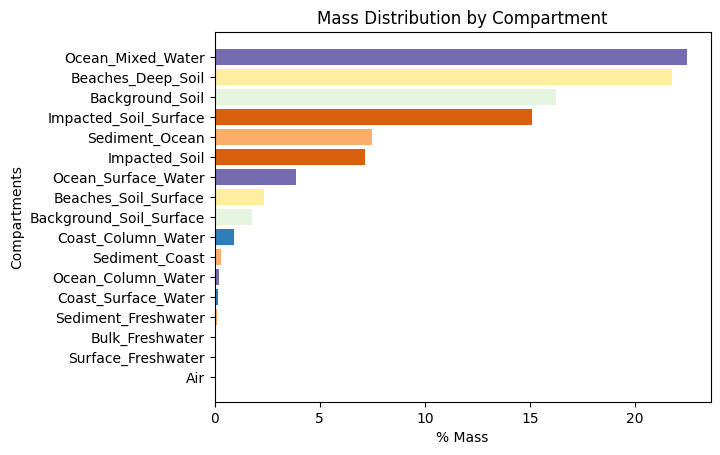

In [38]:
import matplotlib.pyplot as plt

# Assuming you have already defined your custom color mapping from earlier:
compartment_colors = {
    "Ocean_Surface_Water": '#756bb1', 
    "Ocean_Mixed_Water": '#756bb1', 
    "Ocean_Column_Water": '#756bb1', 
    "Coast_Surface_Water": '#2c7fb8', 
    "Coast_Column_Water": '#2c7fb8', 
    "Surface_Freshwater": '#9ebcda', 
    "Bulk_Freshwater": '#9ebcda', 
    "Sediment_Freshwater": '#fdae6b', 
    "Sediment_Ocean": '#fdae6b', 
    "Sediment_Coast": '#fdae6b', 
    "Beaches_Soil_Surface": '#ffeda0', 
    "Beaches_Deep_Soil": '#ffeda0', 
    "Background_Soil_Surface": '#e5f5e0', 
    "Background_Soil": '#e5f5e0', 
    "Impacted_Soil_Surface": '#d95f0e', 
    "Impacted_Soil": '#d95f0e', 
    "Air": '#deebf7'
}

# Add your dataframe sorting and rounding logic
df = results_by_comp[["Compartments", "%_mass"]].round(2).sort_values(by="%_mass", ascending=False)

# Get the list of colors based on the Compartments in the df
bar_colors = df["Compartments"].map(compartment_colors)

# Plot the horizontal bar chart
plt.barh(df["Compartments"], df["%_mass"], color=bar_colors)  # Apply specific colors to each bar
plt.xlabel('% Mass')
plt.ylabel('Compartments')
plt.title('Mass Distribution by Compartment')
plt.gca().invert_yaxis()  # Invert y-axis to match sorting order
plt.show()


In [39]:
results_by_comp[["Compartments","%_number"]].round(2).sort_values(by="%_number", ascending=False)

,Compartments,%_number
14,Impacted_Soil_Surface,66.54
15,Impacted_Soil,31.83
7,Sediment_Freshwater,0.79
11,Beaches_Deep_Soil,0.25
8,Sediment_Ocean,0.22
13,Background_Soil,0.17
16,Air,0.12
9,Sediment_Coast,0.02
2,Ocean_Column_Water,0.02
10,Beaches_Soil_Surface,0.02


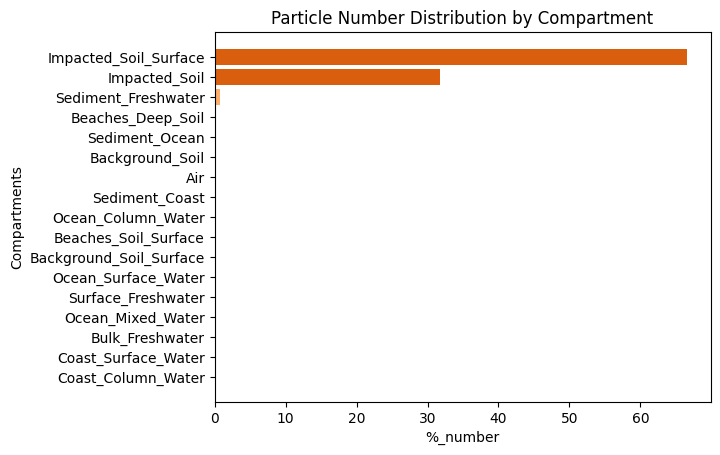

In [40]:
# Add your dataframe sorting and rounding logic
df = results_by_comp[["Compartments", "%_number"]].round(2).sort_values(by="%_number", ascending=False)

# Get the list of colors based on the Compartments in the df
bar_colors = df["Compartments"].map(compartment_colors)

# Plot the horizontal bar chart
plt.barh(df["Compartments"], df["%_number"], color=bar_colors)  # Apply specific colors to each bar
plt.xlabel('%_number')
plt.ylabel('Compartments')
plt.title('Particle Number Distribution by Compartment')
plt.gca().invert_yaxis()  # Invert y-axis to match sorting order
plt.show()

#### Size fraction distribution

In [41]:
## Mass and particle number distribution by size fraction
size_distr = [0.5, 5, 50, 500, 5000]
Pmass = []
Pnumber = []
for size in size_distr:
    Pmass.append(
        round(
            sum(
                Results_extended[Results_extended["Size_Fraction_um"] == size][
                    "mass_g"
                ]
            )
            / sum(Results_extended["mass_g"])
            * 100,
            2,
        )
    )
    Pnumber.append(
        round(
            sum(
                Results_extended[Results_extended["Size_Fraction_um"] == size][
                    "number_of_particles"
                ]
            )
            / sum(Results_extended["number_of_particles"])
            * 100,
            2,
        )
    )

size_distribution_df = pd.DataFrame(
    {
        "Size_Fraction_um": size_distr,
        "% of total mass": Pmass,
        "% of total particle number": Pnumber,
    }
)
size_distribution_df

,Size_Fraction_um,% of total mass,% of total particle number
0,0.5,0.06,97.09
1,5.0,1.73,2.88
2,50.0,22.88,0.04
3,500.0,72.31,0.00
4,5000.0,3.02,0.00


In [42]:
form_distr={}
for form in ["freeMP","heterMP", "biofMP", "heterBiofMP"]:
    form_distr[form]=round(sum(Results_extended[Results_extended["MP_Form"] == form]["number_of_particles"])/sum(Results_extended["number_of_particles"])*100,2)

pd.DataFrame.from_dict(form_distr, orient="index", columns=["% of total particle number"])

,% of total particle number
freeMP,0.00
heterMP,4.43
biofMP,0.00
heterBiofMP,95.57


#### Overall persistence and residence time in years

### Extract input and output flows per compartment


In [43]:
results_comp_extended=add_output_flow_conexions(results_by_comp,dict_comp,outputflow_type="outflows_g_s",inputflow_type="inflows_g_s")
results_comp_extended=add_output_flow_conexions(results_by_comp,dict_comp,outputflow_type="outflows_num_s",inputflow_type="inflows_num_s")

In [44]:
# Import necessary libraries
import os
import pandas as pd

# Define excluded size fractions
excluded_sizes = [0.5, 5]

# Filter out the excluded size fractions
filtered_Results = Results[~Results['Size_Fraction_um'].isin(excluded_sizes)]

# Define the columns to aggregate
aggregation_columns = {
    'mass_g': 'sum',
    'number_of_particles': 'sum',
    'concentration_g_m3': 'sum',
    'concentration_num_m3': 'sum',
    'mass_fraction': 'sum' if 'mass_fraction' in Results.columns else None,
    'number_fraction': 'sum' if 'number_fraction' in Results.columns else None,
}

# Remove None values from aggregation_columns
aggregation_columns = {k: v for k, v in aggregation_columns.items() if v is not None}

# Aggregate data for the filtered DataFrame
aggregated_results = filtered_Results.groupby(['Compartment', 'Size_Fraction_um']).agg(**{
    col: (col, agg_func) for col, agg_func in aggregation_columns.items()
}).reset_index()

# Calculate relative abundance
aggregated_results['relative_abundance'] = aggregated_results.groupby('Compartment')['concentration_num_m3'].transform(
    lambda x: (x / x.sum()) * 100
)

# Calculate percentage of number_of_particles
aggregated_results['percentage_number_of_particles'] = aggregated_results.groupby('Compartment')['number_of_particles'].transform(
    lambda x: (x / x.sum()) * 100
)

# Select only existing columns
output_columns_filtered = [
    'Compartment', 
    'Size_Fraction_um', 
    'mass_g', 
    'number_of_particles', 
    'percentage_number_of_particles',
    'concentration_g_m3', 
    'concentration_num_m3', 
    'mass_fraction', 
    'number_fraction', 
    'relative_abundance'
]

output_columns_filtered = [col for col in output_columns_filtered if col in aggregated_results.columns]

# Extract relevant columns for final output
aggregated_results_output = aggregated_results[output_columns_filtered]

# Define output directory
outputs_path = os.path.join(os.getcwd(), "Results")
current_date = pd.Timestamp.now().strftime("%Y-%m-%d")
directory = current_date
path = os.path.join(outputs_path, directory)

# Create a subdirectory based on the model run name
subDirectory = current_date + "_Filtered_Compartments"
path_run = os.path.join(path, subDirectory)

# Ensure the directory exists
os.makedirs(path_run, exist_ok=True)

# Save the filtered aggregated results to an Excel file
filtered_output_excel_path = os.path.join(path_run, "Filtered_Aggregated_Results.xlsx")
aggregated_results_output.to_excel(filtered_output_excel_path, index=False)

print(f"Filtered aggregated results saved to {filtered_output_excel_path}")


Filtered aggregated results saved to c:\Users\rakes\Pictures\Model\UTOPIA_model-main\Results\2025-02-17\2025-02-17_Filtered_Compartments\Filtered_Aggregated_Results.xlsx


Observed Data Preview:


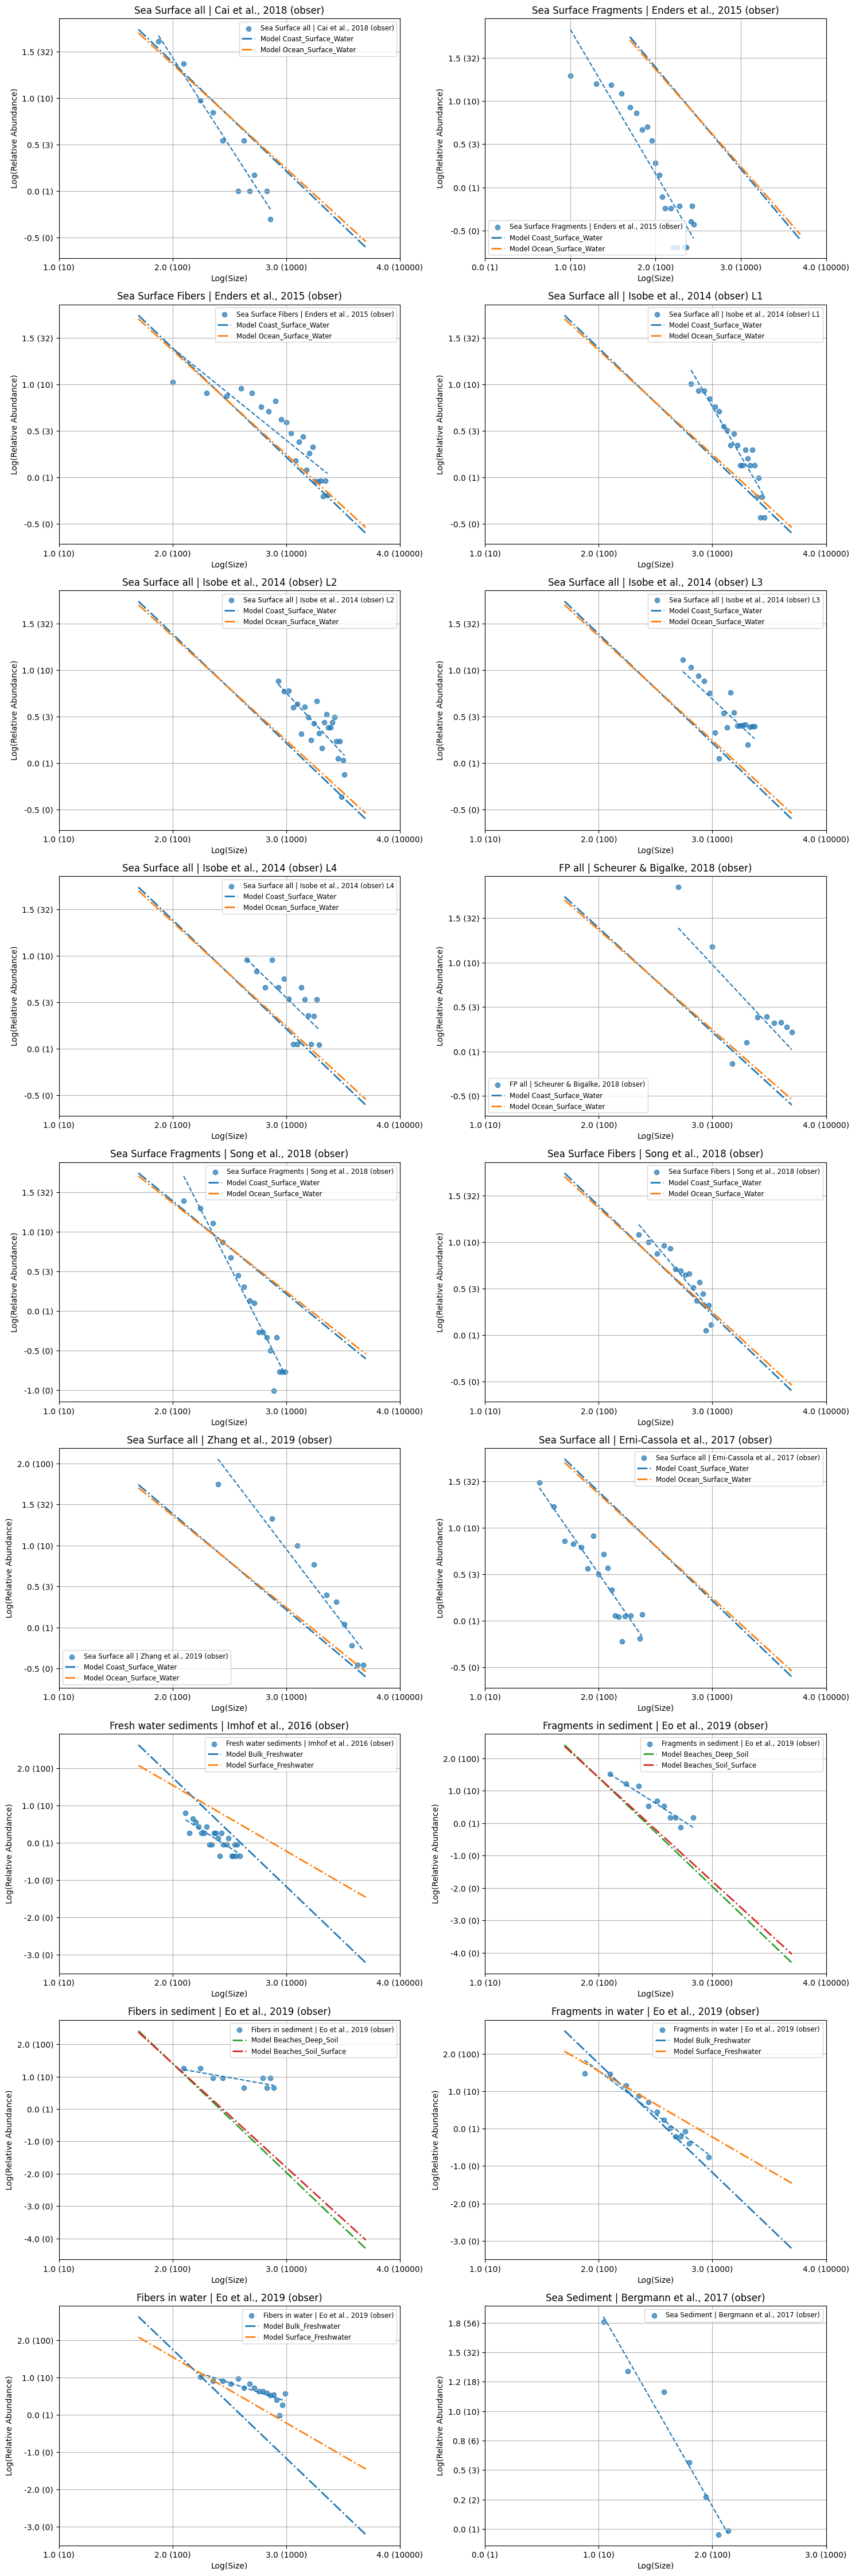

Comparison data appended to 'Model vs Observed Raw.xlsx'.


In [45]:
import os
import math
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from zipfile import BadZipFile

#############################################
# NOTE: Define required variables if not already defined.
#############################################
# Example definitions (adjust as needed or remove if already defined):
# aggregated_results = pd.read_csv("your_model_output.csv")
# input_flow_g_s = 0.5
# MPdensity_kg_m3 = 0.001
# desired_key = "Receiving_Compartment"   # or derived from q_mass_g_s_dict
# MP_form = "Some_Form"
# size_dict = {"bin1": 1000}
# size_bin = "bin1"
# FI = "Some_FI_value"
# t_half_deg_free = 5.0
# heter_deg_factor = 0.8
# biof_deg_factor = 1.2
# factor_deepWater_soilSurface = 0.9
# factor_sediment = 1.1
# t_frag_gen_FreeSurfaceWater = 2.5
# biof_frag_factor = 0.7
# heter_frag_factor = 1.3

#############################################
# 1. Process the Observed Data
#############################################

observed_file = "your_dataset.xlsx"  # Update path if needed
observed_data = pd.read_excel(observed_file)
print("Observed Data Preview:")
#print(observed_data.head())

# Assume each dataset is stored in two columns ("Size1", "Abundance1", "Size2", "Abundance2", etc.)
processed_data = {}
columns = observed_data.columns
num_datasets = len(columns) // 2
for i in range(1, num_datasets + 1):
    size_col = f"Size{i}"
    abundance_col = f"Abundance{i}"
    df = observed_data[[size_col, abundance_col]].dropna()
    df = df[df[abundance_col] > 0]
    df['log_size'] = np.log10(df[size_col])
    df['log_abundance'] = np.log10(df[abundance_col])
    processed_data[f"Dataset{i}"] = df

# Define observed dataset names.
dataset_names = {
    "Dataset1": "Sea Sediment | Bergmann et al., 2017 (obser)",
    "Dataset2": "Sea Surface all | Cai et al., 2018 (obser)",
    "Dataset3": "Sea Surface Fragments | Enders et al., 2015 (obser)",
    "Dataset4": "Sea Surface Fibers | Enders et al., 2015 (obser)",
    "Dataset5": "Fragments in water | Eo et al., 2019 (obser)",
    "Dataset6": "Fibers in water | Eo et al., 2019 (obser)",
    "Dataset7": "Fragments in sediment | Eo et al., 2019 (obser)",
    "Dataset8": "Fibers in sediment | Eo et al., 2019 (obser)",
    "Dataset9": "Sea Surface all | Erni-Cassola et al., 2017 (obser)",
    "Dataset10": "Fresh water sediments | Imhof et al., 2016 (obser)",
    "Dataset11": "Sea Surface all | Isobe et al., 2014 (obser) L1",
    "Dataset12": "Sea Surface all | Isobe et al., 2014 (obser) L2",
    "Dataset13": "Sea Surface all | Isobe et al., 2014 (obser) L3",
    "Dataset14": "Sea Surface all | Isobe et al., 2014 (obser) L4",
    "Dataset15": "FP all | Scheurer & Bigalke, 2018 (obser)",
    "Dataset16": "Sea Surface Fragments | Song et al., 2018 (obser)",
    "Dataset17": "Sea Surface Fibers | Song et al., 2018 (obser)",
    "Dataset18": "Sea Surface all | Zhang et al., 2019 (obser)"
}

# Updated overlay mapping.
overlay_compartments_mapping = {
    "Sea Sediment | Bergmann et al., 2017": ["Sediment_Coast", "Sediment_Ocean"],
    "Sea Surface all | Cai et al., 2018": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fragments | Enders et al., 2015": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Enders et al., 2015": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fragments in water | Eo et al., 2019": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fibers in water | Eo et al., 2019": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fragments in sediment | Eo et al., 2019": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil", "Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Fibers in sediment | Eo et al., 2019": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil", "Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Sea Surface all | Erni-Cassola et al., 2017": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fresh water sediments | Imhof et al., 2016": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Sea Surface all | Isobe et al., 2014 L1": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Isobe et al., 2014 L2": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Isobe et al., 2014 L3": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Isobe et al., 2014 L4": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "FP all | Scheurer & Bigalke, 2018": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fragments | Song et al., 2018": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Song et al., 2018": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Zhang et al., 2019": ["Coast_Surface_Water", "Ocean_Surface_Water"]
}

#############################################
# 2. Process the Model Simulation Output (again)
#############################################

# Process model data from aggregated_results.
data_model = aggregated_results[aggregated_results['relative_abundance'] > 0].copy()
data_model['log_size'] = np.log10(data_model['Size_Fraction_um'])
data_model['log_abundance'] = np.log10(data_model['relative_abundance'])

# Compute linear trendlines for each model compartment.
compartment_trendlines = {}
for comp in data_model['Compartment'].unique():
    comp_data = data_model[data_model['Compartment'] == comp]
    if len(comp_data) > 1:
        coeffs = np.polyfit(comp_data['log_size'], comp_data['log_abundance'], 1)
        trendline_func = np.poly1d(coeffs)
        x_vals = np.linspace(comp_data['log_size'].min(), comp_data['log_size'].max(), 100)
        y_vals = trendline_func(x_vals)
        compartment_trendlines[comp] = {'x_vals': x_vals, 'y_vals': y_vals, 'func': trendline_func}

#############################################
# 3. Plotting: Observed Data with Model Overlays
#############################################

# Define the plotting order.
ordered_keys = [
    "Dataset2", "Dataset3", "Dataset4", "Dataset11",
    "Dataset12", "Dataset13", "Dataset14", "Dataset15",
    "Dataset16", "Dataset17", "Dataset18", "Dataset9",
    "Dataset10", "Dataset7", "Dataset8", "Dataset5",
    "Dataset6", "Dataset1"
]

# Create subplots.
n_datasets = len(ordered_keys)
rows_subplot = math.ceil(n_datasets / 2)
fig, axs = plt.subplots(rows_subplot, 2, figsize=(15, rows_subplot * 5))
axs = axs.flatten()

for i, dataset_key in enumerate(ordered_keys):
    df = processed_data[dataset_key]
    ax = axs[i]
    full_title = dataset_names.get(dataset_key, dataset_key)
    ax.scatter(df['log_size'], df['log_abundance'], label=full_title, alpha=0.7)
    
    # Plot observed trendline.
    if len(df) > 1:
        coeffs_obs = np.polyfit(df['log_size'], df['log_abundance'], 1)
        trendline_obs = np.poly1d(coeffs_obs)
        x_vals_obs = np.linspace(df['log_size'].min(), df['log_size'].max(), 100)
        ax.plot(x_vals_obs, trendline_obs(x_vals_obs), linestyle='--', label="_nolegend_")
    
    base_title = full_title.replace(" (obser)", "").strip()
    if base_title in overlay_compartments_mapping:
        for j, comp in enumerate(overlay_compartments_mapping[base_title]):
            if comp in compartment_trendlines:
                ax.plot(compartment_trendlines[comp]['x_vals'],
                        compartment_trendlines[comp]['y_vals'],
                        color=plt.get_cmap("tab10").colors[j % 10],
                        linestyle='-.', linewidth=2,
                        label=f"Model {comp}")
    
    ax.set_xlabel("Log(Size)")
    ax.set_ylabel("Log(Relative Abundance)")
    ax.set_title(full_title)
    ax.grid(True)
    ax.legend(fontsize='small', loc='best')
    
    # Custom tick formatter.
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.1f} ({10**x:.0f})"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:.1f} ({10**y:.0f})"))
    
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.arange(np.floor(xmin), np.ceil(xmax) + 1, 1))

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

#############################################
# 4. Save Plot Images in a Separate Folder with Unique Names
#############################################
# Create a timestamp for this run.
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

plot_folder = "plots"
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

for dataset_key in ordered_keys:
    df = processed_data[dataset_key]
    full_title = dataset_names.get(dataset_key, dataset_key)
    plt.figure(figsize=(8,6))
    plt.scatter(df['log_size'], df['log_abundance'], label=full_title, alpha=0.7)
    if len(df) > 1:
        coeffs_obs = np.polyfit(df['log_size'], df['log_abundance'], 1)
        trendline_obs = np.poly1d(coeffs_obs)
        x_vals_obs = np.linspace(df['log_size'].min(), df['log_size'].max(), 100)
        plt.plot(x_vals_obs, trendline_obs(x_vals_obs), linestyle='--', label="Obs Trendline")
    base_title = full_title.replace(" (obser)", "").strip()
    if base_title in overlay_compartments_mapping:
        for j, comp in enumerate(overlay_compartments_mapping[base_title]):
            if comp in compartment_trendlines:
                plt.plot(compartment_trendlines[comp]['x_vals'],
                         compartment_trendlines[comp]['y_vals'],
                         color=plt.get_cmap("tab10").colors[j % 10],
                         linestyle='-.', linewidth=2,
                         label=f"Model {comp}")
    plt.xlabel("Log(Size)")
    plt.ylabel("Log(Relative Abundance)")
    plt.title(full_title)
    plt.grid(True)
    plt.legend(fontsize='small', loc='best')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.1f} ({10**x:.0f})"))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:.1f} ({10**y:.0f})"))
    plt.tight_layout()
    # Save the image with a unique filename that includes the timestamp.
    img_filename = os.path.join(plot_folder, f"graph_{dataset_key}_{timestamp}.png")
    plt.savefig(img_filename, bbox_inches="tight")
    plt.close()

#############################################
# 5. Export Comparison Data to Excel (Separate Sheets, Append New Rows)
#############################################

excel_file = "Model vs Observed Raw.xlsx"

try:
    if os.path.exists(excel_file):
        writer = pd.ExcelWriter(excel_file, engine="openpyxl", mode='a', if_sheet_exists='overlay')
    else:
        writer = pd.ExcelWriter(excel_file, engine="openpyxl")
except BadZipFile:
    print("Existing Excel file is corrupted. Removing it and creating a new file.")
    os.remove(excel_file)
    writer = pd.ExcelWriter(excel_file, engine="openpyxl")

for dataset_key, df in processed_data.items():
    full_title = dataset_names.get(dataset_key, dataset_key)
    base_title = full_title.replace(" (obser)", "").strip()
    # Build the mini plot link using the timestamp.
    mini_plot_link = os.path.join(plot_folder, f"graph_{dataset_key}_{timestamp}.png")
    
    sheet_data = []
    
    if base_title in overlay_compartments_mapping:
        for comp in overlay_compartments_mapping[base_title]:
            if comp in compartment_trendlines:
                model_func = compartment_trendlines[comp]['func']
                model_coeffs = model_func.coefficients
                model_slope = model_coeffs[0]
                model_intercept = model_coeffs[1]
                
                observed_x = df['log_size']
                observed_y = df['log_abundance']
                x_vals_model = compartment_trendlines[comp]['x_vals']
                min_model_x = np.min(x_vals_model)
                max_model_x = np.max(x_vals_model)
                mask = (observed_x >= min_model_x) & (observed_x <= max_model_x)
                if np.sum(mask) < 2:
                    r2 = np.nan
                    obs_slope = np.nan
                    obs_intercept = np.nan
                    euclidean_distance = np.nan
                    rmse = np.nan
                else:
                    observed_x_filtered = observed_x[mask]
                    observed_y_filtered = observed_y[mask]
                    obs_coeffs = np.polyfit(observed_x_filtered, observed_y_filtered, 1)
                    obs_slope = obs_coeffs[0]
                    obs_intercept = obs_coeffs[1]
                    predicted_y_filtered = model_func(observed_x_filtered)
                    ss_res = np.sum((observed_y_filtered - predicted_y_filtered)**2)
                    ss_tot = np.sum((observed_y_filtered - np.mean(observed_y_filtered))**2)
                    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan
                    rmse = np.sqrt(ss_res / np.sum(mask))  # RMSE calculation
                    euclidean_distance = np.sqrt((model_slope - obs_slope)**2 + (model_intercept - obs_intercept)**2)
                sheet_data.append({
                    'Observed Dataset': full_title,
                    'Model Compartment': comp,
                    'Model slope': model_slope,
                    'Observed slope': obs_slope,
                    'Model intercept': model_intercept,
                    'Observed intercept': obs_intercept,
                    'Euclidean distance': euclidean_distance,
                    'R-squared': r2,
                    'RMSE': rmse,
                    'n_points': int(np.sum(mask)),
                    'mini plot': mini_plot_link,
                    'Emissions flow (g/s)': input_flow_g_s,
                    'Emitted MP density (kg/m3)': MPdensity_kg_m3,
                    'Receiving compartment/s': desired_key,
                    'Emitted MP form': MP_form,
                    'Emitted MP size (um)': size_dict[size_bin],
                    'frag_styles_dict': FI,
                    't_half_deg_free': t_half_deg_free,
                    'heter_deg_factor': heter_deg_factor,
                    'biof_deg_factor': biof_deg_factor,
                    'factor_deepWater_soilSurface': factor_deepWater_soilSurface,
                    'factor_sediment': factor_sediment,
                    't_frag_gen_FreeSurfaceWater': t_frag_gen_FreeSurfaceWater,
                    'biof_frag_factor': biof_frag_factor,
                    'heter_frag_factor': heter_frag_factor
                })
    else:
        sheet_data.append({
            'Observed Dataset': full_title,
            'Model Compartment': pd.NA,
            'Model slope': pd.NA,
            'Observed slope': pd.NA,
            'Model intercept': pd.NA,
            'Observed intercept': pd.NA,
            'Euclidean distance': pd.NA,
            'R-squared': pd.NA,
            'RMSE': pd.NA,
            'n_points': pd.NA,
            'mini plot': mini_plot_link,
            'Emissions flow (g/s)': input_flow_g_s,
            'Emitted MP density (kg/m3)': MPdensity_kg_m3,
            'Receiving compartment/s': desired_key,
            'Emitted MP form': MP_form,
            'Emitted MP size (um)': size_dict[size_bin],
            'frag_styles_dict': FI,
            't_half_deg_free': pd.NA,
            'heter_deg_factor': pd.NA,
            'biof_deg_factor': pd.NA,
            'factor_deepWater_soilSurface': pd.NA,
            'factor_sediment': pd.NA,
            't_frag_gen_FreeSurfaceWater': pd.NA,
            'biof_frag_factor': pd.NA,
            'heter_frag_factor': pd.NA
        })
    
    new_sheet_df = pd.DataFrame(sheet_data)
    
    # Do NOT convert the mini plot column into a hyperlink formula; leave it as plain text.
    
    # Generate a valid sheet name. For the Isobe datasets, use a custom shortened name.
    if full_title.startswith("Sea Surface all | Isobe et al., 2014"):
        m = re.search(r"L\d", full_title)
        l_val = m.group(0) if m else ""
        sheet_name = f"Sea Sur all | Isobe | {l_val}"
    else:
        sheet_name = full_title.replace(" (obser)", "").replace("|", "").replace(" ", "_")[:31]
    
    try:
        existing_df = pd.read_excel(excel_file, sheet_name=sheet_name)
        combined_df = pd.concat([existing_df, new_sheet_df], ignore_index=True)
    except Exception as e:
        combined_df = new_sheet_df
    
    cols_order = [
        'Observed Dataset', 'Model Compartment',
        'Model slope', 'Observed slope', 'Model intercept', 'Observed intercept',
        'Euclidean distance', 'R-squared', 'RMSE', 'n_points', 'mini plot',
        'Emissions flow (g/s)', 'Emitted MP density (kg/m3)', 'Receiving compartment/s',
        'Emitted MP form', 'Emitted MP size (um)', 'frag_styles_dict', 't_half_deg_free',
        'heter_deg_factor', 'biof_deg_factor', 'factor_deepWater_soilSurface', 'factor_sediment',
        't_frag_gen_FreeSurfaceWater', 'biof_frag_factor', 'heter_frag_factor'
    ]
    for col in cols_order:
        if col not in combined_df.columns:
            combined_df[col] = np.nan
    combined_df = combined_df[cols_order]
    
    combined_df.to_excel(writer, sheet_name=sheet_name, index=False)

writer.close()
print("Comparison data appended to 'Model vs Observed Raw.xlsx'.")
